
# Projeto Integrado — Deep Learning

Integrantes:  
Arthur  
358843  
Eduardo  
359302  
Gustavo  
358496  
Wagner   
360191

# O QUE É ESPERADO COMO ENTREGA? 
A solução implementada utilizando modelos de Deep Learning com Tensorflow para as   
4 ações e outras soluções diferenciadas e inovadores (opcional) que possam ser   
aplicadas ao conjunto de dados proposto.  
 • Devem ser entregues em formato de Jupyter Notebook;  
 As quatro ações devem ter modelos treinados, e devem ser apresentados os seguintes 
indicadores:  
 • Acurácia no conjunto de teste  de cada modelo;  
 • Matriz de confusão, precision e recall de cada modelo;  
 • Desempenho financeiro do modelo via ‘backtest’ com o objetivo de responder se o 
modelo gerado   
daria retorno financeiro (opcional pois é um assunto de finanças, se 
não fizer não há prejuízo na nota final);

In [1]:

# ================== SETUP & CONFIG ==================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report
from IPython.display import display, Markdown

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

CONFIG = {
    'DATA_DIR': Path('bases'),
    'FILES': {
        'VALE3': {'train': 'VALE3SA/treino.csv', 'test': 'VALE3SA/teste.csv'},
        'PETR4': {'train': 'PETR4SA/treino.csv', 'test': 'PETR4SA/teste.csv'},
        'BBAS3': {'train': 'BBAS3SA/treino.csv', 'test': 'BBAS3SA/teste.csv'},
        'CSNA3': {'train': 'CSNA3SA/treino.csv', 'test': 'CSNA3SA/teste.csv'},
    },
    'LABEL_COL': 'Label',
    'DATE_COL': 'Date',
    'CLOSE_COL': 'Close',
    'WINDOW': 15,
}

LAG_COLS = [f"Past_{i}_Days_Close" for i in range(1, CONFIG['WINDOW']+1)]


In [2]:

# ================== FUNÇÕES ==================
def load_pair(ticker: str):
    base = CONFIG['DATA_DIR']
    train_rel = CONFIG['FILES'][ticker]['train']
    test_rel  = CONFIG['FILES'][ticker]['test']
    df_tr = pd.read_csv(base / train_rel)
    df_te = pd.read_csv(base / test_rel)
    return df_tr, df_te

def parse_dates_inplace(df: pd.DataFrame):
    dc = CONFIG['DATE_COL']
    if dc in df.columns:
        df[dc] = pd.to_datetime(df[dc], errors='coerce')

def prepare_xy(df: pd.DataFrame):
    X = df[LAG_COLS].astype(float).values
    y = df[CONFIG['LABEL_COL']].astype(int).values
  
    uniq = sorted(pd.unique(y))
    
    return X, y

def scale_and_reshape(Xtr, Xte):
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(Xtr)
    Xte_s = scaler.transform(Xte)
    Xtr_seq = Xtr_s.reshape(-1, CONFIG['WINDOW'], 1)
    Xte_seq = Xte_s.reshape(-1, CONFIG['WINDOW'], 1)
    return Xtr_s, Xte_s, Xtr_seq, Xte_seq



## EDA
Inclui:
- `head()` do treino e do teste + listagem de colunas
- dimensão e período de datas (min/max) se houver `Date`
- distribuição de rótulos (contagem e %), **treino** e **teste**
- série temporal de `Close` (treino e teste)
- **heatmap** de correlação entre os 15 lags (treino)


# VALE3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.829122,1.752574,1,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375,1.600482
1,2,2000-01-25,1.829122,1.760229,1,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375,1.562375
2,3,2000-01-26,1.813879,1.765594,1,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375,1.562375
3,4,2000-01-27,1.829122,1.771947,1,1.813879,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535,1.562375
4,5,2000-01-28,1.829122,1.777664,1,1.829122,1.813879,1.829122,1.829122,1.791015,1.829122,1.840554,1.848175,1.905335,1.867229,1.832933,1.773867,1.756719,1.752908,1.619535


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,32.196571,31.573791,1,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266,30.368454
1,4810,2019-02-27,31.944181,31.610830,1,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816,28.963266
2,4811,2019-02-28,32.128353,31.662583,1,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762,28.369816
3,4812,2019-03-01,31.882784,31.684603,1,32.128353,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134,29.440762
4,4813,2019-03-06,32.776375,31.793780,1,31.882784,32.128353,31.944181,32.196571,32.141998,32.053322,30.955091,31.241589,31.030128,30.866413,31.296162,31.146086,31.030128,30.218393,28.663134


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4808, 20) / (1203, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-02-25 00:00:00  
- **Período teste:** 2019-02-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2716, 1: 2092}  
**Treino (%):** {-1: 56.49, 1: 43.51}

**Teste:** {-1: 601, 1: 602}  
**Teste (%):** {-1: 49.96, 1: 50.04}

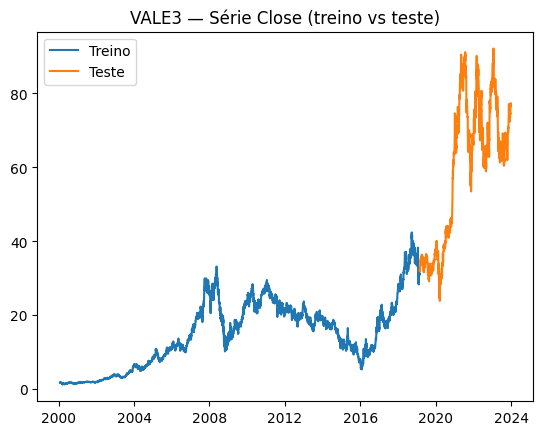

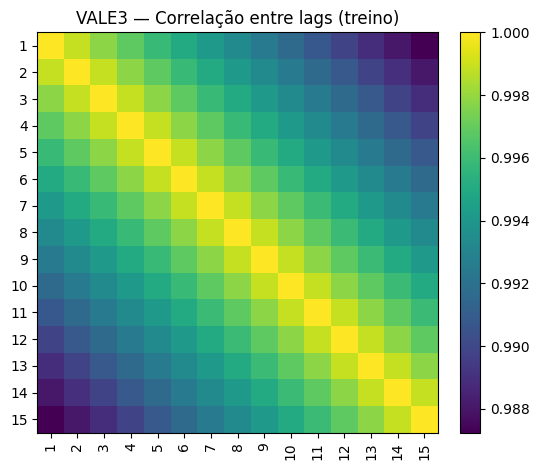

# PETR4 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.274788,1.347845,-1,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341,1.450586
1,2,2000-01-25,1.274788,1.340540,-1,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514,1.370341
2,3,2000-01-26,1.290096,1.335495,-1,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823,1.356514
3,4,2000-01-27,1.280960,1.330042,-1,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995,1.351823
4,5,2000-01-28,1.280960,1.325134,-1,1.280960,1.290096,1.274788,1.274788,1.283923,1.311824,1.314787,1.324169,1.317996,1.333305,1.314787,1.353798,1.351823,1.385896,1.357995


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4809,2019-02-26,9.467936,9.376527,1,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673,9.289832
1,4810,2019-02-27,9.646040,9.403478,1,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191,9.079673
2,4811,2019-02-28,9.638913,9.427022,1,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439,8.937191
3,4812,2019-03-01,9.510681,9.435388,1,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140,8.951439
4,4813,2019-03-06,9.532050,9.445054,1,9.510681,9.638913,9.646040,9.467936,9.510681,9.663848,9.760024,9.631790,9.752899,9.532050,9.560549,9.599731,9.279146,9.161598,8.848140


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4808, 20) / (1203, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-02-25 00:00:00  
- **Período teste:** 2019-02-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2654, 1: 2154}  
**Treino (%):** {-1: 55.2, 1: 44.8}

**Teste:** {-1: 581, 1: 622}  
**Teste (%):** {-1: 48.3, 1: 51.7}

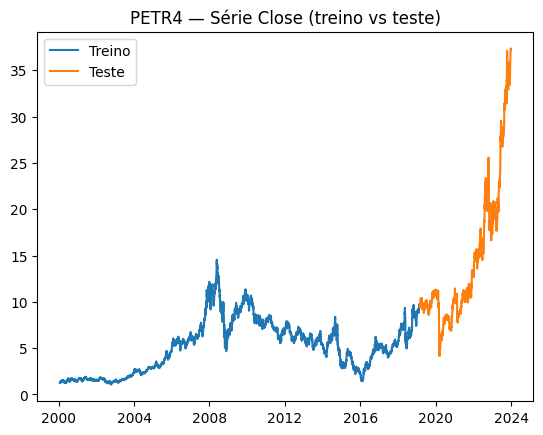

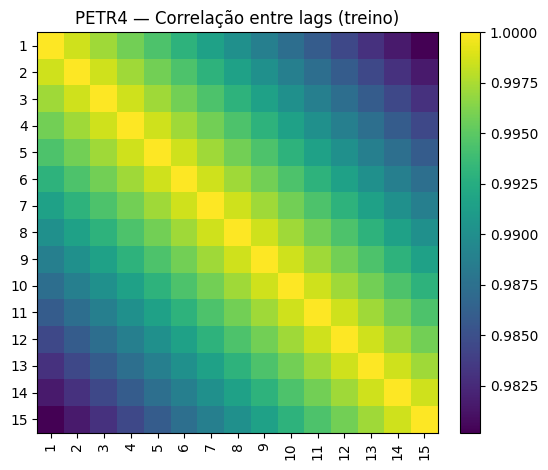

# BBAS3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.062769,1.071645,-1,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457,1.074564
1,2,2000-01-26,1.087668,1.073247,-1,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940,1.023457
2,3,2000-01-27,1.064080,1.072330,-1,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355,1.033940
3,4,2000-01-28,1.036561,1.068753,-1,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767,1.048355
4,5,2000-01-31,1.035250,1.065403,-1,1.036561,1.064080,1.087668,1.062769,1.088979,1.079805,1.086357,1.098152,1.069322,1.061459,1.062769,1.081116,1.066701,1.081116,1.024767


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4736,2019-03-26,36.386158,37.917648,-1,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866,37.898129
1,4737,2019-03-27,34.371300,37.563014,-1,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150,37.395866
2,4738,2019-03-28,35.571316,37.363844,-1,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489,37.248150
3,4739,2019-03-29,36.089863,37.236446,-1,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267,38.555489
4,4740,2019-04-01,36.445412,37.157342,-1,36.089863,35.571316,34.371300,36.386158,35.549099,35.297241,37.326935,38.126942,39.001053,39.852917,40.156639,39.815880,40.119583,39.512161,39.737267


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4735, 20) / (1185, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-03-25 00:00:00  
- **Período teste:** 2019-03-26 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2602, 1: 2133}  
**Treino (%):** {-1: 54.95, 1: 45.05}

**Teste:** {-1: 689, 1: 496}  
**Teste (%):** {-1: 58.14, 1: 41.86}

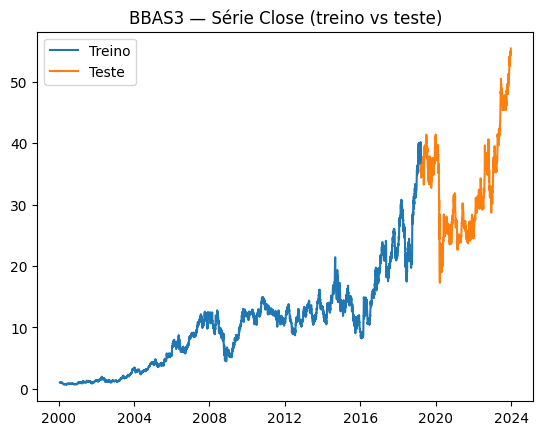

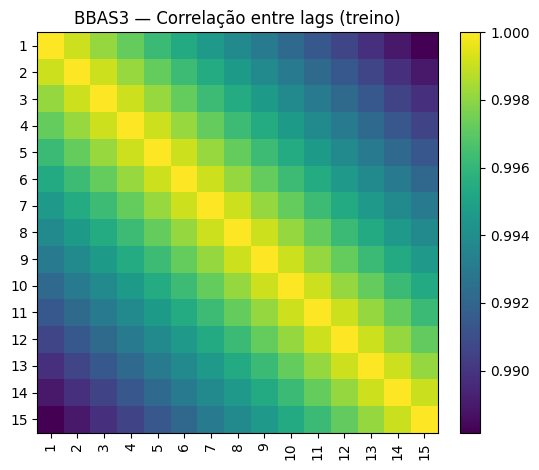

# CSNA3 — EDA

### treino.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,1,2000-01-24,1.409986,1.588954,-1,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777,1.658908
1,2,2000-01-26,1.398052,1.569864,-1,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139,1.682777
2,3,2000-01-27,1.375888,1.550466,-1,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271,1.773139
3,4,2000-01-28,1.363953,1.531815,-1,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336,1.853271
4,5,2000-01-31,1.329854,1.511619,-1,1.363953,1.375888,1.398052,1.409986,1.375888,1.478184,1.522513,1.566841,1.594120,1.500348,1.546381,1.704941,1.785073,1.863500,1.841336


**Colunas (treino):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

### teste.csv — head()

,Unnamed: 0,Date,Close,Smoothed_Close,Label,Past_1_Days_Close,Past_2_Days_Close,Past_3_Days_Close,Past_4_Days_Close,Past_5_Days_Close,Past_6_Days_Close,Past_7_Days_Close,Past_8_Days_Close,Past_9_Days_Close,Past_10_Days_Close,Past_11_Days_Close,Past_12_Days_Close,Past_13_Days_Close,Past_14_Days_Close,Past_15_Days_Close
0,4744,2019-03-25,9.917939,9.592937,1,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026,8.706488
1,4745,2019-03-26,10.543634,9.688007,1,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350,9.219026
2,4746,2019-03-27,10.004474,9.719654,1,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440,10.084350
3,4747,2019-03-28,10.437135,9.791402,1,10.004474,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118,9.811440
4,4748,2019-03-29,10.816545,9.893916,1,10.437135,10.004474,10.543634,9.917939,9.957878,10.370573,10.583574,10.437135,10.849827,10.390541,10.250756,10.310663,9.432028,9.691624,9.159118


**Colunas (teste):** ['Unnamed: 0', 'Date', 'Close', 'Smoothed_Close', 'Label', 'Past_1_Days_Close', 'Past_2_Days_Close', 'Past_3_Days_Close', 'Past_4_Days_Close', 'Past_5_Days_Close', 'Past_6_Days_Close', 'Past_7_Days_Close', 'Past_8_Days_Close', 'Past_9_Days_Close', 'Past_10_Days_Close', 'Past_11_Days_Close', 'Past_12_Days_Close', 'Past_13_Days_Close', 'Past_14_Days_Close', 'Past_15_Days_Close']

- **Tamanho treino/teste:** (4743, 20) / (1186, 20)  
- **Período treino:** 2000-01-24 00:00:00 → 2019-03-22 00:00:00  
- **Período teste:** 2019-03-25 00:00:00 → 2023-12-28 00:00:00

### Distribuição de rótulos

**Treino:** {-1: 2655, 1: 2088}  
**Treino (%):** {-1: 55.98, 1: 44.02}

**Teste:** {-1: 688, 1: 498}  
**Teste (%):** {-1: 58.01, 1: 41.99}

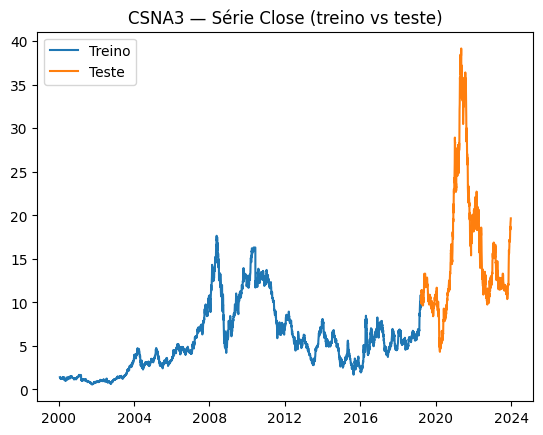

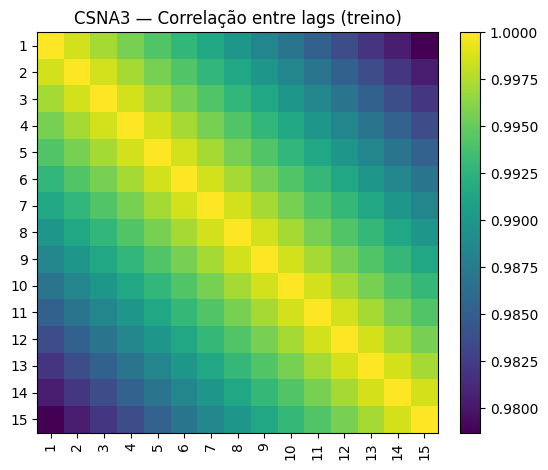

In [3]:

for ticker in CONFIG['FILES'].keys():
    df_tr, df_te = load_pair(ticker)
    parse_dates_inplace(df_tr)
    parse_dates_inplace(df_te)

    display(Markdown(f"# {ticker} — EDA"))
    display(Markdown("### treino.csv — head()"))
    display(df_tr.head())
    display(Markdown(f"**Colunas (treino):** {list(df_tr.columns)}"))
    display(Markdown("### teste.csv — head()"))
    display(df_te.head())
    display(Markdown(f"**Colunas (teste):** {list(df_te.columns)}"))

    dc = CONFIG['DATE_COL']
    tr_dates = (df_tr[dc].min(), df_tr[dc].max()) if dc in df_tr.columns else (None, None)
    te_dates = (df_te[dc].min(), df_te[dc].max()) if dc in df_te.columns else (None, None)
    display(Markdown(
        f"- **Tamanho treino/teste:** {df_tr.shape} / {df_te.shape}  \n"
        f"- **Período treino:** {tr_dates[0]} → {tr_dates[1]}  \n"
        f"- **Período teste:** {te_dates[0]} → {te_dates[1]}"
    ))

    ytr = df_tr[CONFIG['LABEL_COL']].astype(int)
    yte = df_te[CONFIG['LABEL_COL']].astype(int)
    ctr = ytr.value_counts().sort_index(); cte = yte.value_counts().sort_index()
    ptr = (ctr / ctr.sum() * 100).round(2); pte = (cte / cte.sum() * 100).round(2)
    display(Markdown("### Distribuição de rótulos"))
    display(Markdown(f"**Treino:** {ctr.to_dict()}  \n**Treino (%):** {ptr.to_dict()}"))
    display(Markdown(f"**Teste:** {cte.to_dict()}  \n**Teste (%):** {pte.to_dict()}"))

    cc = CONFIG['CLOSE_COL']
    if cc in df_tr.columns and cc in df_te.columns:
        fig, ax = plt.subplots()
        if dc in df_tr.columns:
            ax.plot(df_tr[dc], df_tr[cc], label="Treino")
        else:
            ax.plot(df_tr[cc].values, label="Treino")
        if dc in df_te.columns:
            ax.plot(df_te[dc], df_te[cc], label="Teste")
        else:
            ax.plot(df_te[cc].values, label="Teste")
        ax.set_title(f"{ticker} — Série Close (treino vs teste)")
        ax.legend()
        plt.show()

    corr = df_tr[LAG_COLS].corr()
    fig, ax = plt.subplots()
    im = ax.imshow(corr.values, interpolation='nearest')
    ax.set_title(f"{ticker} — Correlação entre lags (treino)")
    ax.set_xticks(range(len(LAG_COLS)))
    ax.set_xticklabels([str(i) for i in range(1, len(LAG_COLS)+1)], rotation=90)
    ax.set_yticks(range(len(LAG_COLS)))
    ax.set_yticklabels([str(i) for i in range(1, len(LAG_COLS)+1)])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()



## Modelagem — MLP (baseline), CNN1D e LSTM


In [4]:

def build_mlp():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'],)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def build_cnn1d():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'], 1)),
        layers.Conv1D(32, kernel_size=3, padding="causal", activation="relu"),
        layers.Conv1D(32, kernel_size=5, padding="causal", activation="relu"),
        layers.GlobalAveragePooling1D(),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def build_lstm():
    model = keras.Sequential([
        layers.Input(shape=(CONFIG['WINDOW'], 1)),
        layers.LSTM(32, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="tanh")
    ])
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

def tanh_to_pm1(pred):
    return np.where(pred.ravel() >= 0, 1, -1)

def eval_model(model, Xtr, ytr, Xte, yte, epochs=25, batch_size=64, verbose=0):
    hist = model.fit(Xtr, ytr, epochs=epochs, batch_size=batch_size, validation_data=(Xte, yte), verbose=verbose)
    yhat = model.predict(Xte, verbose=0)
    ypred = tanh_to_pm1(yhat)
    acc = accuracy_score(yte, ypred)
    cm  = confusion_matrix(yte, ypred, labels=[-1, 1])
    pr, rc, f1, _ = precision_recall_fscore_support(yte, ypred, labels=[1], average=None)
    return {"accuracy": acc, "precision_+1": pr[0], "recall_+1": rc[0], "f1_+1": f1[0], "cm": cm, "history": hist.history, "ypred": ypred}


In [5]:

# ================== EXECUÇÃO POR TICKER ==================
def run_all_models():
    all_results = []
    cms = {}
    ypred_store = {}  
    ytrue_store = {}  
    for ticker in CONFIG['FILES'].keys():
        df_tr, df_te = load_pair(ticker)
        Xtr, ytr = prepare_xy(df_tr); Xte, yte = prepare_xy(df_te)
        ytrue_store[ticker] = yte
        Xtr_s, Xte_s, Xtr_seq, Xte_seq = scale_and_reshape(Xtr, Xte)

        # MLP
        mlp = build_mlp()
        r_mlp = eval_model(mlp, Xtr_s, ytr, Xte_s, yte)
        all_results.append({"ticker": ticker, "model": "MLP", **{k:v for k,v in r_mlp.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"MLP")] = r_mlp["cm"]; ypred_store[(ticker,"MLP")] = r_mlp["ypred"]

        # CNN1D
        cnn = build_cnn1d()
        r_cnn = eval_model(cnn, Xtr_seq, ytr, Xte_seq, yte)
        all_results.append({"ticker": ticker, "model": "CNN1D", **{k:v for k,v in r_cnn.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"CNN1D")] = r_cnn["cm"]; ypred_store[(ticker,"CNN1D")] = r_cnn["ypred"]

        # LSTM
        lstm = build_lstm()
        r_lstm = eval_model(lstm, Xtr_seq, ytr, Xte_seq, yte)
        all_results.append({"ticker": ticker, "model": "LSTM", **{k:v for k,v in r_lstm.items() if k not in ('cm','history','ypred')}})
        cms[(ticker,"LSTM")] = r_lstm["cm"]; ypred_store[(ticker,"LSTM")] = r_lstm["ypred"]
    return all_results, cms, ypred_store, ytrue_store

all_results, cms, ypred_store, ytrue_store = run_all_models()

tbl = pd.DataFrame(all_results, columns=["ticker","model","accuracy","precision_+1","recall_+1","f1_+1"]) 
tbl.sort_values(["ticker","f1_+1","accuracy"], ascending=[True, False, False], inplace=True)
display(Markdown("### **Consolidado — Métricas por ativo/modelo**"))
display(tbl)

# ====== Métricas detalhadas por ativo/modelo ======
for (ticker, model), ypred in ypred_store.items():
    y_true = ytrue_store[ticker]
    acc = accuracy_score(y_true, ypred)
    cm = confusion_matrix(y_true, ypred, labels=[-1, 1])
    pre, rec, f1, sup = precision_recall_fscore_support(y_true, ypred, labels=[-1, 1], zero_division=0)
    report = classification_report(y_true, ypred, target_names=["SELL(-1)", "BUY(+1)"], digits=4, zero_division=0)

    display(Markdown(f"## {ticker} — {model}"))
    display(Markdown(f"**Acurácia (teste):** {acc:.4f}"))

    cm_df = pd.DataFrame(cm, index=["Verdade -1","Verdade +1"], columns=["Pred -1","Pred +1"]) 
    display(Markdown("**Matriz de confusão:**")); display(cm_df)

    pr_df = pd.DataFrame({
        "Classe": ["-1","+1"],
        "Precision": [pre[0], pre[1]],
        "Recall": [rec[0], rec[1]],
        "F1": [f1[0], f1[1]],
        "Suporte": [sup[0], sup[1]],
    })
    display(Markdown("**Precision/Recall/F1:**")); display(pr_df)

    display(Markdown("**Classification report (texto):**"))
    print(report)


### **Consolidado — Métricas por ativo/modelo**

,ticker,model,accuracy,precision_+1,recall_+1,f1_+1
6,BBAS3,MLP,0.828692,0.715125,0.981855,0.827528
7,BBAS3,CNN1D,0.825316,0.914040,0.643145,0.755030
8,BBAS3,LSTM,0.711392,0.636042,0.725806,0.677966
9,CSNA3,MLP,0.884486,0.813913,0.939759,0.872321
10,CSNA3,CNN1D,0.866779,0.851240,0.827309,0.839104
11,CSNA3,LSTM,0.766442,0.726899,0.710843,0.718782
3,PETR4,MLP,0.852037,0.847962,0.869775,0.858730
4,PETR4,CNN1D,0.837905,0.840510,0.847267,0.843875
5,PETR4,LSTM,0.610973,0.640511,0.564309,0.600000
0,VALE3,MLP,0.846218,0.773982,0.978405,0.864270


## VALE3 — MLP

**Acurácia (teste):** 0.8462

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,429,172
Verdade +1,13,589


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.970588,0.713810,0.822627,601
1,+1,0.773982,0.978405,0.864270,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9706    0.7138    0.8226       601
     BUY(+1)     0.7740    0.9784    0.8643       602

    accuracy                         0.8462      1203
   macro avg     0.8723    0.8461    0.8434      1203
weighted avg     0.8722    0.8462    0.8435      1203



## VALE3 — CNN1D

**Acurácia (teste):** 0.8313

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,410,191
Verdade +1,12,590


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.971564,0.682196,0.801564,601
1,+1,0.755442,0.980066,0.853218,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9716    0.6822    0.8016       601
     BUY(+1)     0.7554    0.9801    0.8532       602

    accuracy                         0.8313      1203
   macro avg     0.8635    0.8311    0.8274      1203
weighted avg     0.8634    0.8313    0.8274      1203



## VALE3 — LSTM

**Acurácia (teste):** 0.6018

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,533,68
Verdade +1,411,191


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.564619,0.886855,0.689968,601
1,+1,0.737452,0.317276,0.443670,602


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.5646    0.8869    0.6900       601
     BUY(+1)     0.7375    0.3173    0.4437       602

    accuracy                         0.6018      1203
   macro avg     0.6510    0.6021    0.5668      1203
weighted avg     0.6511    0.6018    0.5667      1203



## PETR4 — MLP

**Acurácia (teste):** 0.8520

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,484,97
Verdade +1,81,541


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.856637,0.833046,0.844677,581
1,+1,0.847962,0.869775,0.858730,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8566    0.8330    0.8447       581
     BUY(+1)     0.8480    0.8698    0.8587       622

    accuracy                         0.8520      1203
   macro avg     0.8523    0.8514    0.8517      1203
weighted avg     0.8522    0.8520    0.8519      1203



## PETR4 — CNN1D

**Acurácia (teste):** 0.8379

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,481,100
Verdade +1,95,527


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.835069,0.827883,0.831461,581
1,+1,0.840510,0.847267,0.843875,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8351    0.8279    0.8315       581
     BUY(+1)     0.8405    0.8473    0.8439       622

    accuracy                         0.8379      1203
   macro avg     0.8378    0.8376    0.8377      1203
weighted avg     0.8379    0.8379    0.8379      1203



## PETR4 — LSTM

**Acurácia (teste):** 0.6110

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,384,197
Verdade +1,271,351


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.586260,0.660929,0.621359,581
1,+1,0.640511,0.564309,0.600000,622


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.5863    0.6609    0.6214       581
     BUY(+1)     0.6405    0.5643    0.6000       622

    accuracy                         0.6110      1203
   macro avg     0.6134    0.6126    0.6107      1203
weighted avg     0.6143    0.6110    0.6103      1203



## BBAS3 — MLP

**Acurácia (teste):** 0.8287

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,495,194
Verdade +1,9,487


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.982143,0.718433,0.829841,689
1,+1,0.715125,0.981855,0.827528,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9821    0.7184    0.8298       689
     BUY(+1)     0.7151    0.9819    0.8275       496

    accuracy                         0.8287      1185
   macro avg     0.8486    0.8501    0.8287      1185
weighted avg     0.8704    0.8287    0.8289      1185



## BBAS3 — CNN1D

**Acurácia (teste):** 0.8253

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,659,30
Verdade +1,177,319


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.788278,0.956459,0.864262,689
1,+1,0.914040,0.643145,0.755030,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7883    0.9565    0.8643       689
     BUY(+1)     0.9140    0.6431    0.7550       496

    accuracy                         0.8253      1185
   macro avg     0.8512    0.7998    0.8096      1185
weighted avg     0.8409    0.8253    0.8185      1185



## BBAS3 — LSTM

**Acurácia (teste):** 0.7114

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,483,206
Verdade +1,136,360


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.780291,0.701016,0.738532,689
1,+1,0.636042,0.725806,0.677966,496


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7803    0.7010    0.7385       689
     BUY(+1)     0.6360    0.7258    0.6780       496

    accuracy                         0.7114      1185
   macro avg     0.7082    0.7134    0.7082      1185
weighted avg     0.7199    0.7114    0.7132      1185



## CSNA3 — MLP

**Acurácia (teste):** 0.8845

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,581,107
Verdade +1,30,468


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.950900,0.844477,0.894534,688
1,+1,0.813913,0.939759,0.872321,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.9509    0.8445    0.8945       688
     BUY(+1)     0.8139    0.9398    0.8723       498

    accuracy                         0.8845      1186
   macro avg     0.8824    0.8921    0.8834      1186
weighted avg     0.8934    0.8845    0.8852      1186



## CSNA3 — CNN1D

**Acurácia (teste):** 0.8668

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,616,72
Verdade +1,86,412


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.877493,0.895349,0.886331,688
1,+1,0.851240,0.827309,0.839104,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.8775    0.8953    0.8863       688
     BUY(+1)     0.8512    0.8273    0.8391       498

    accuracy                         0.8668      1186
   macro avg     0.8644    0.8613    0.8627      1186
weighted avg     0.8665    0.8668    0.8665      1186



## CSNA3 — LSTM

**Acurácia (teste):** 0.7664

**Matriz de confusão:**

,Pred -1,Pred +1
Verdade -1,555,133
Verdade +1,144,354


**Precision/Recall/F1:**

,Classe,Precision,Recall,F1,Suporte
0,-1,0.793991,0.806686,0.800288,688
1,+1,0.726899,0.710843,0.718782,498


**Classification report (texto):**

              precision    recall  f1-score   support

    SELL(-1)     0.7940    0.8067    0.8003       688
     BUY(+1)     0.7269    0.7108    0.7188       498

    accuracy                         0.7664      1186
   macro avg     0.7604    0.7588    0.7595      1186
weighted avg     0.7658    0.7664    0.7661      1186



In [6]:
def highlight_max_custom(s):
    is_max = s == s.max()
    return ['background-color: #2ecc71; color: black; font-weight: bold;' if v else '' for v in is_max]

pivot = tbl.pivot(index="ticker", columns="model", values="accuracy")
display(Markdown("### Destaque por linha (maior accuracy)"))
display(pivot.style.apply(highlight_max_custom, axis=1))

### Destaque por linha (maior accuracy)

model,CNN1D,LSTM,MLP
ticker,,,
BBAS3,0.825316,0.711392,0.828692
CSNA3,0.866779,0.766442,0.884486
PETR4,0.837905,0.610973,0.852037
VALE3,0.831255,0.601829,0.846218



## Backtest 
Compara **Buy & Hold** vs. a **estratégia** 


### **VALE3**

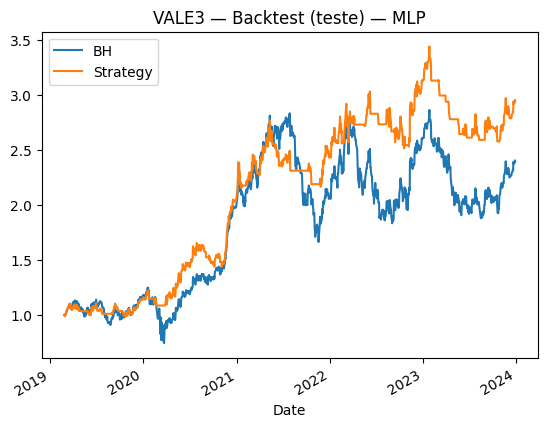

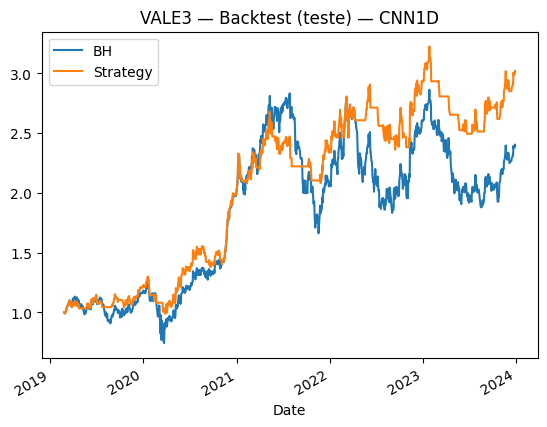

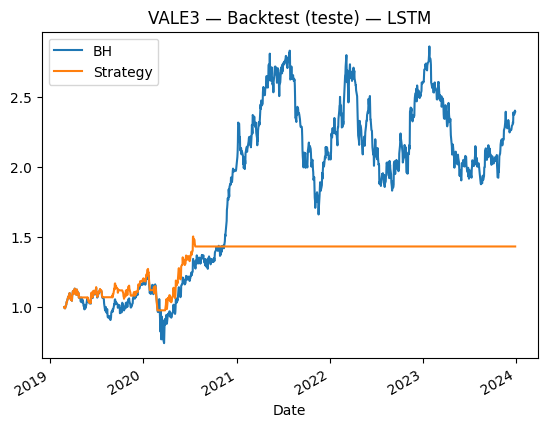

### **PETR4**

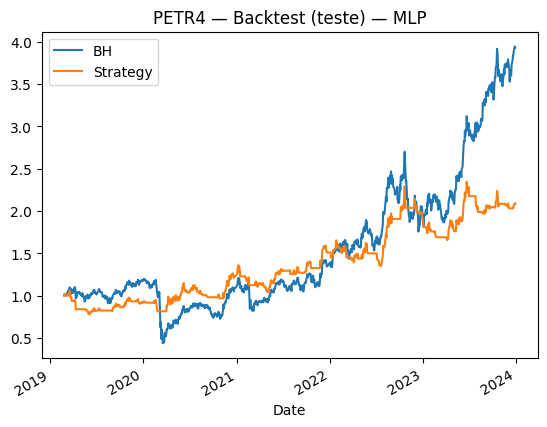

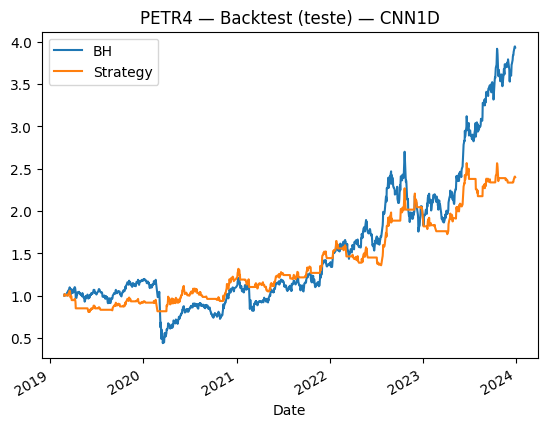

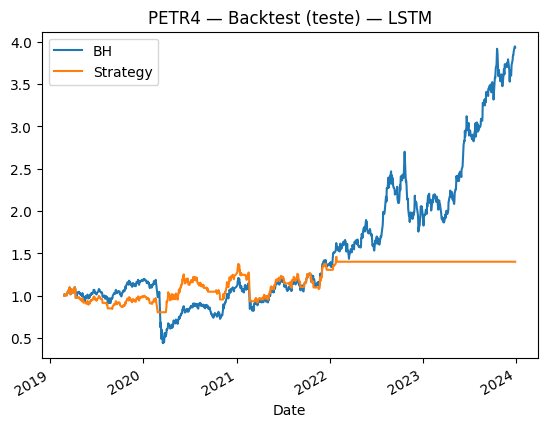

### **BBAS3**

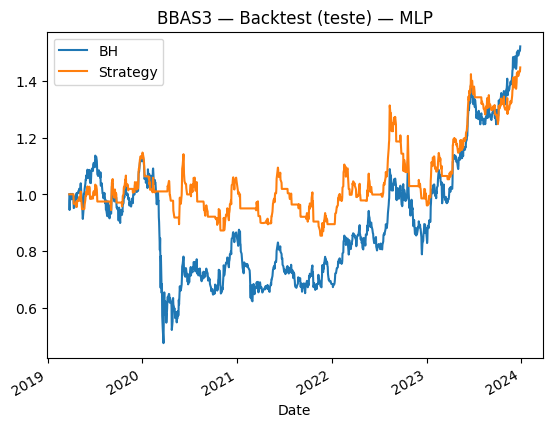

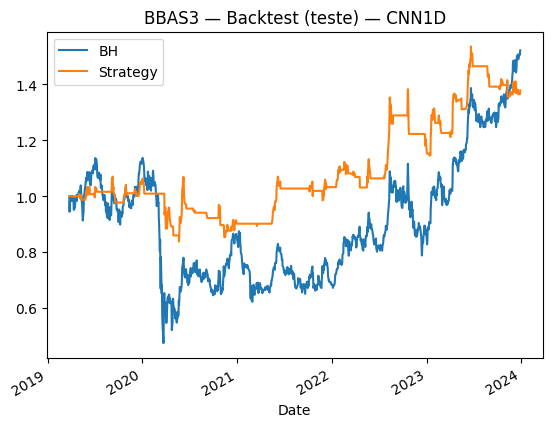

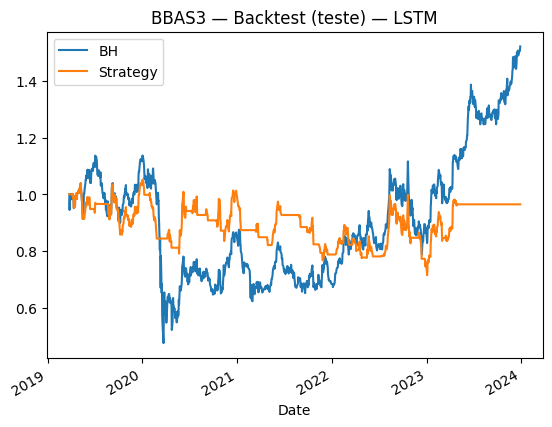

### **CSNA3**

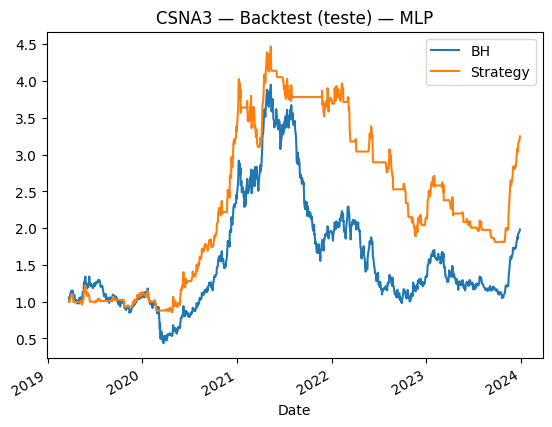

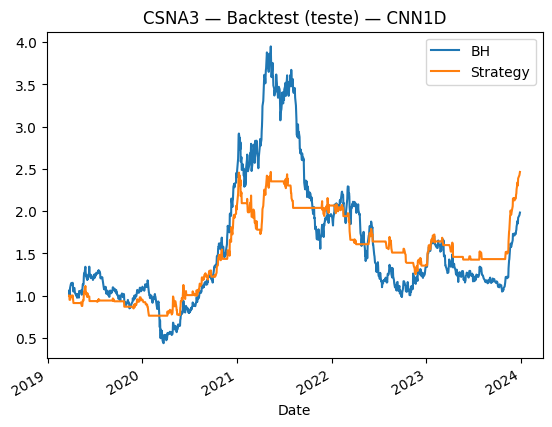

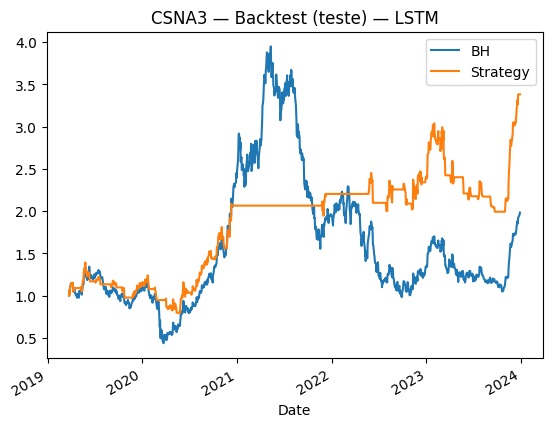

In [7]:

def backtest_equity_curve(df_test: pd.DataFrame, ypred_pm1: np.ndarray, date_col: str, close_col: str):
    # posição long/flat
    pos = (ypred_pm1 == 1).astype(int)
    close = df_test[close_col].astype(float).values
    ret = pd.Series(close).pct_change().fillna(0).values

    strat_eq = (1 + ret * pos).cumprod()
    bh_eq = (1 + ret).cumprod()

    if date_col in df_test.columns:
        idx = pd.to_datetime(df_test[date_col], errors='coerce')
    else:
        idx = pd.RangeIndex(len(df_test))

    return pd.DataFrame({"BH": bh_eq, "Strategy": strat_eq}, index=idx)

for ticker in CONFIG['FILES'].keys():
    display(Markdown(f"### **{ticker}**"))
    _, df_te = load_pair(ticker)
    for model in ["MLP","CNN1D","LSTM"]:
        eq = backtest_equity_curve(df_te, ypred_store[(ticker, model)], CONFIG['DATE_COL'], CONFIG['CLOSE_COL'])
        fig, ax = plt.subplots()
        eq.plot(ax=ax)
        ax.set_title(f"{ticker} — Backtest (teste) — {model}")
        plt.show()


# Análise das imagens

In [ ]:
# ========= CNN 2D (comprar vs vender) =========
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)


TICKER = "CSNA3" 
ROOT   = Path("bases") / f"{TICKER}SA" / "imagens"
TRAIN_DIR, TEST_DIR = ROOT/"treino", ROOT/"teste"

IMG_SIZE = (128, 128)
BATCH    = 32
AUTOTUNE = tf.data.AUTOTUNE

ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode='binary', seed=SEED)
ds_test  = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,  image_size=IMG_SIZE, batch_size=BATCH, label_mode='binary', seed=SEED)

class_names = ds_train.class_names  # ['comprar','vender']
normalizer  = keras.Sequential([layers.Rescaling(1/255.)])

ds_train = ds_train.map(lambda x,y: (normalizer(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
ds_test  = ds_test.map(lambda x,y: (normalizer(x), y),  num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

print("Classes:", class_names)


Found 4743 files belonging to 2 classes.
Found 1186 files belonging to 2 classes.
Classes: ['comprar', 'vender']


C:\Users\eduhs\AppData\Local\Temp\ipykernel_13464\1954765914.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(class_names[int(y.numpy())])


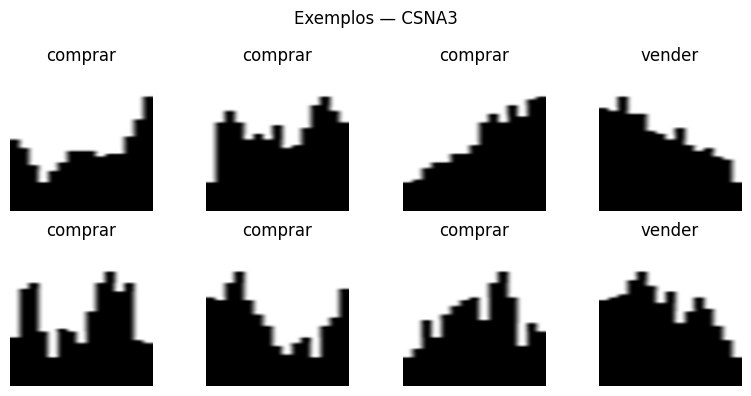

In [4]:

plt.figure(figsize=(8,4))
for i,(x,y) in enumerate(ds_train.unbatch().take(8)):
    plt.subplot(2,4,i+1)
    plt.imshow(x.numpy())
    plt.axis("off")
    plt.title(class_names[int(y.numpy())])
plt.suptitle(f"Exemplos — {TICKER}")
plt.tight_layout(); plt.show()


In [5]:
# --- CNN 2D  ---
model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE,3)),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128,3, padding='same', activation='relu'),
    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')   # binário: comprar(0)/vender(1)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 34s 218ms/step - accuracy: 0.6595 - loss: 0.5983 - precision: 0.6414 - recall: 0.8885 - val_accuracy: 0.8558 - val_loss: 0.3248 - val_precision: 0.8243 - val_recall: 0.9549
Epoch 2/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 208ms/step - accuracy: 0.8689 - loss: 0.3030 - precision: 0.8846 - recall: 0.8806 - val_accuracy: 0.8153 - val_loss: 0.4270 - val_precision: 0.9958 - val_recall: 0.6846
Epoch 3/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 32s 213ms/step - accuracy: 0.8786 - loss: 0.2840 - precision: 0.8981 - recall: 0.8832 - val_accuracy: 0.8777 - val_loss: 0.2700 - val_precision: 0.9289 - val_recall: 0.8547
Epoch 4/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 32s 212ms/step - accuracy: 0.8781 - loss: 0.2722 - precision: 0.8941 - recall: 0.8874 - val_accuracy: 0.8786 - val_loss: 0.2747 - val_precision: 0.9401 - val_recall: 0.8445
Epoch 5/15
149/149 ━━━━━━━━━━━━━━━━━━━━ 31s 211ms/step - accuracy: 0.8824 - loss: 0.2715 - precision: 0.8985 - recall: 0.8904 - val_accuracy: 0.8685

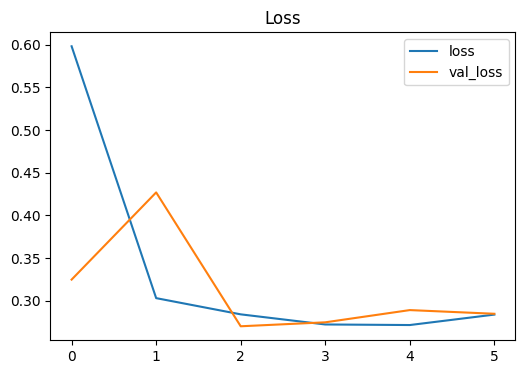

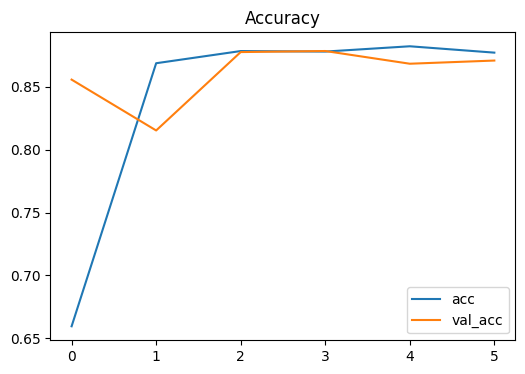

In [6]:
# --- treino básico com early stopping ---
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
history = model.fit(ds_train, validation_data=ds_test, epochs=15, callbacks=callbacks, verbose=1)

# curvas
h = history.history
plt.figure(figsize=(6,4)); plt.plot(h['loss'], label='loss'); plt.plot(h['val_loss'], label='val_loss'); plt.legend(); plt.title('Loss'); plt.show()
plt.figure(figsize=(6,4)); plt.plot(h['accuracy'], label='acc'); plt.plot(h['val_accuracy'], label='val_acc'); plt.legend(); plt.title('Accuracy'); plt.show()


Teste — Acc: 0.878  Precision: 0.929  Recall: 0.855  F1: 0.890

Relatório por classe (0 = comprar, 1 = vender):
              precision    recall  f1-score   support

     comprar       0.82      0.91      0.86       498
      vender       0.93      0.85      0.89       688

    accuracy                           0.88      1186
   macro avg       0.87      0.88      0.88      1186
weighted avg       0.88      0.88      0.88      1186



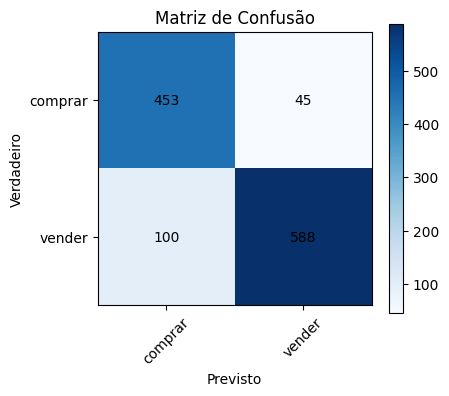

In [7]:
# --- avaliação no teste ---
# rótulos verdadeiros e probabilidades
y_true = np.concatenate([y.numpy().ravel() for _, y in ds_test])
y_prob = np.concatenate([model.predict(x, verbose=0).ravel() for x,_ in ds_test])
y_pred = (y_prob >= 0.5).astype(int)  # limiar simples de 0.5

acc = (y_pred == y_true).mean()
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])

print(f"Teste — Acc: {acc:.3f}  Precision: {prec:.3f}  Recall: {rec:.3f}  F1: {f1:.3f}")
print("\nRelatório por classe (0 = comprar, 1 = vender):")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

# matriz de confusão
plt.figure(figsize=(4.6,4))
plt.imshow(cm, cmap='Blues'); plt.title('Matriz de Confusão'); plt.colorbar()
ticks = np.arange(len(class_names)); plt.xticks(ticks, class_names, rotation=45); plt.yticks(ticks, class_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.tight_layout(); plt.show()


In [13]:
EPOCHS   = 15
VAL_SPLIT= 0.15

TICKERS = ["VALE3", "PETR4", "BBAS3"]


def image_root_for(ticker: str) -> Path:
    return Path("bases") / f"{ticker}SA" / "imagens"


In [14]:
# ==== FUNÇÕES DE DADOS ====
def load_image_datasets(root: Path, img_size=IMG_SIZE, batch=BATCH, seed=SEED, val_split=VAL_SPLIT):
    train_dir = root/"treino"
    test_dir  = root/"teste"
    if not train_dir.exists() or not test_dir.exists():
        return None

    # treino + validação a partir do diretório de treino
    ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed, validation_split=val_split, subset='training'
    )
    ds_val = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir, image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed, validation_split=val_split, subset='validation'
    )
    ds_test = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,  image_size=img_size, batch_size=batch,
        label_mode='binary', seed=seed
    )

    class_names = ds_train.class_names  # ['comprar','vender']
    norm = keras.Sequential([layers.Rescaling(1/255.)])
    ds_train = ds_train.map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().shuffle(1000, seed=seed).prefetch(AUTOTUNE)
    ds_val   = ds_val  .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    ds_test  = ds_test .map(lambda x,y: (norm(x), y), num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)
    return ds_train, ds_val, ds_test, class_names

def count_by_class(split_dir: Path, classes):
    exts = {".png",".jpg",".jpeg",".bmp",".gif"}
    return {c: sum(1 for f in (split_dir/c).rglob("*") if f.suffix.lower() in exts) for c in classes}


In [15]:
# ==== MODELO ====
def build_cnn2d(img_size=IMG_SIZE):
    model = keras.Sequential([
        layers.Input(shape=(*img_size, 3)),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128,3, padding='same', activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')])
    return model


In [16]:
# ==== TREINO + AVALIAÇÃO ====
def train_and_eval_for_ticker(ticker: str):
    root = image_root_for(ticker)
    ds = load_image_datasets(root)
    if ds is None:
        return {'ticker': ticker, 'status': 'sem_imagens'}

    ds_train, ds_val, ds_test, class_names = ds
    # pesos de classe (opcional, ajuda se desbalanceado)
    train_counts = count_by_class(root/"treino", class_names)
    tot = sum(train_counts.values())
    class_weight = {0: tot/(2*train_counts[class_names[0]]) if train_counts[class_names[0]] else 1.0,
                    1: tot/(2*train_counts[class_names[1]]) if train_counts[class_names[1]] else 1.0}

    model = build_cnn2d()
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)]
    history = model.fit(ds_train, validation_data=ds_val, epochs=EPOCHS, callbacks=callbacks, class_weight=class_weight, verbose=0)

    # avaliação no TESTE
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds_test])
    y_prob = np.concatenate([model.predict(x, verbose=0).ravel() for x,_ in ds_test])
    y_pred = (y_prob >= 0.5).astype(int)

    acc = (y_pred == y_true).mean()
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])

    # relatório por classe (string simples para o notebook)
    cls_report = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

    return {
        'ticker': ticker,
        'status': 'ok',
        'class_names': class_names,
        'train_counts': train_counts,
        'metrics': {'acc': float(acc), 'precision': float(prec), 'recall': float(rec), 'f1': float(f1)},
        'cm': cm,
        'report': cls_report,
        'history': history.history
    }


=== VALE3 ===
Found 4808 files belonging to 2 classes.
Using 4087 files for training.
Found 4808 files belonging to 2 classes.
Using 721 files for validation.
Found 1203 files belonging to 2 classes.
Teste — Acc: 0.877  Precision: 0.871  Recall: 0.885  F1: 0.878
              precision    recall  f1-score   support

     comprar       0.88      0.87      0.88       602
      vender       0.87      0.89      0.88       601

    accuracy                           0.88      1203
   macro avg       0.88      0.88      0.88      1203
weighted avg       0.88      0.88      0.88      1203



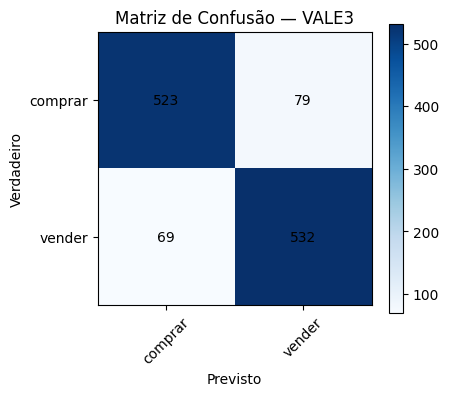

=== PETR4 ===
Found 4808 files belonging to 2 classes.
Using 4087 files for training.
Found 4808 files belonging to 2 classes.
Using 721 files for validation.
Found 1203 files belonging to 2 classes.
Teste — Acc: 0.865  Precision: 0.872  Recall: 0.845  F1: 0.858
              precision    recall  f1-score   support

     comprar       0.86      0.88      0.87       622
      vender       0.87      0.85      0.86       581

    accuracy                           0.87      1203
   macro avg       0.87      0.86      0.87      1203
weighted avg       0.87      0.87      0.87      1203



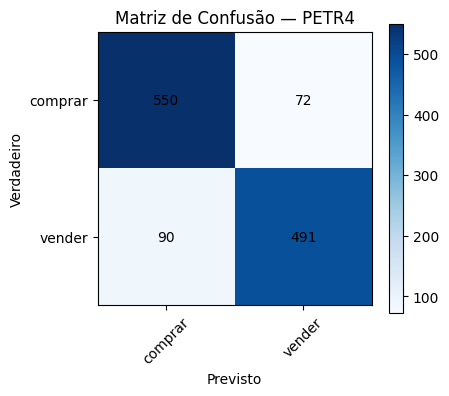

=== BBAS3 ===
Found 4735 files belonging to 2 classes.
Using 4025 files for training.
Found 4735 files belonging to 2 classes.
Using 710 files for validation.
Found 1185 files belonging to 2 classes.
Teste — Acc: 0.886  Precision: 0.898  Recall: 0.907  F1: 0.903
              precision    recall  f1-score   support

     comprar       0.87      0.86      0.86       496
      vender       0.90      0.91      0.90       689

    accuracy                           0.89      1185
   macro avg       0.88      0.88      0.88      1185
weighted avg       0.89      0.89      0.89      1185



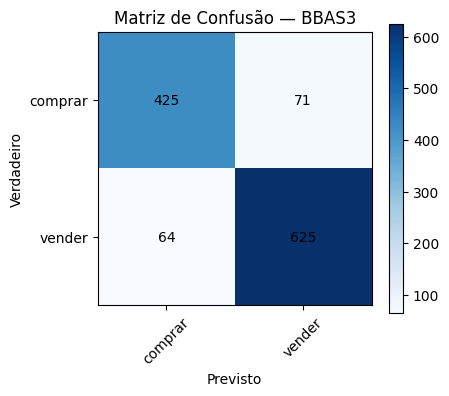

NameError: name 'pd' is not defined

In [ ]:
# ==== LOOP 
results = []
for t in TICKERS:
    print(f"=== {t} ===")
    out = train_and_eval_for_ticker(t)
    if out['status'] == 'ok':
        m = out['metrics']
        print(f"Teste — Acc: {m['acc']:.3f}  Precision: {m['precision']:.3f}  Recall: {m['recall']:.3f}  F1: {m['f1']:.3f}")
        print(out['report'])
        # plot da matriz de confusão
        cm = out['cm']; classes = out['class_names']
        plt.figure(figsize=(4.6,4))
        plt.imshow(cm, cmap='Blues'); plt.title(f'Matriz de Confusão — {t}'); plt.colorbar()
        ticks = np.arange(len(classes)); plt.xticks(ticks, classes, rotation=45); plt.yticks(ticks, classes)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i,j], ha='center', va='center', color='black')
        plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.tight_layout(); plt.show()

        results.append({'Ticker': t, 'Acc': m['acc'], 'Precision': m['precision'], 'Recall': m['recall'], 'F1': m['f1']})
    else:
        print("Pastas de imagens não encontradas — pulando.")
        results.append({'Ticker': t, 'Acc': np.nan, 'Precision': np.nan, 'Recall': np.nan, 'F1': np.nan})

df_res = pd.DataFrame(results).set_index('Ticker').round(3)
df_res
